# DATASET (Agulhas)

In [1]:
import xrft
import os
import numpy as np
import xarray as xr
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import torch
import torch.nn as nn
import torch.nn.functional as F

from models.CNN import CNN
from utils import plot_examples

%matplotlib inline

In [2]:
PERSISTENT_BUCKET = 'gs://leap-persistent/dhruvbalwada'
unfiltered_link = PERSISTENT_BUCKET + '/ssh_reconstruction_project/unfiltered_data.zarr'
filtered_link = PERSISTENT_BUCKET+'/ssh_reconstruction_project/filtered_data.zarr'

In [3]:
da_unfiltered = xr.open_zarr(unfiltered_link)['ssh_unfiltered']
da_filtered = xr.open_zarr(filtered_link)['ssh_filtered']
da_it = da_unfiltered - da_filtered

## Data Plotting

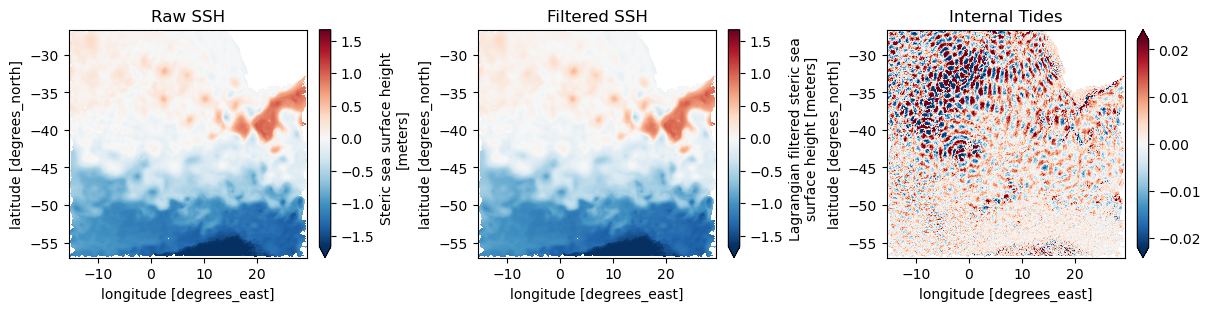

In [5]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 3), constrained_layout=True)

da_unfiltered.isel(time=-1).plot(x='x0', y='y0', robust=True, ax=axes[0])
axes[0].set_title('Raw SSH')

da_filtered.isel(time=-1).plot(x='x0', y='y0', robust= True, ax=axes[1])
axes[1].set_title('Filtered SSH')

da_it.isel(time=-1).plot(x='x0', y='y0',robust=True, ax=axes[2])
axes[2].set_title('Internal Tides')

plt.show()

In [5]:
def prewitt_filter(input):
    # Sobel operator kernels
    kernel_x = torch.tensor([[+1, 0, -1], [+1, 0, -1], [+1, 0, -1]], dtype=torch.float32).view(1, 1, 3, 3)
    kernel_y = torch.tensor([[+1, +1, +1], [0, 0, 0], [-1, -1, -1]], dtype=torch.float32).view(1, 1, 3, 3)

    # Compute gradients using Sobel filters
    gradient_x = F.conv2d(input, kernel_x, padding=1)
    gradient_y = F.conv2d(input, kernel_y, padding=1)

    return gradient_x, gradient_y

def sobel_filter(input):
    # Sobel operator kernels
    kernel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).view(1, 1, 3, 3)
    kernel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).view(1, 1, 3, 3)

    # Compute gradients using Sobel filters
    gradient_x = F.conv2d(input, kernel_x, padding=1)
    gradient_y = F.conv2d(input, kernel_y, padding=1)

    return gradient_x, gradient_y

def laplacian_filter(input_image):
    laplacian_kernel = torch.tensor([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=torch.float32)
    laplacian_kernel = laplacian_kernel.view(1, 1, 3, 3)
    
    return F.conv2d(input_image, laplacian_kernel, padding=1)

def prewitt_3d_filter(input_image):
    kernel = torch.tensor([[[[1, 1, 1], [1, -8, 1], [1, 1, 1]]]], dtype=torch.float32)
    kernel = kernel.repeat((1, 1, 3, 1, 1))
    input_image = input_image.repeat((1, 3, 1, 1))
    
    return F.conv3d(input_image, kernel, padding=1)

def plot_filter_outputs(**kwargs):
    num_subplots = len(kwargs)
    fig, axes = plt.subplots(nrows=num_subplots, figsize=(16, 5*num_subplots))
    
    for idx, (kwarg, value) in enumerate(kwargs.items()):
        xr.DataArray(value.squeeze(), dims=['x', 'y']).plot(x='x', y='y', robust=True, yincrease=False, ax=axes[idx])
        axes[idx].set_title(kwarg)
        
    plt.show()

def plot_power_spectrum(**kwargs):

    fig, ax = plt.subplots(figsize=(16, 7))
    
    for idx, (kwarg, value) in enumerate(kwargs.items()):

        da = xr.DataArray(value.squeeze(), dims=['x', 'y'])
        ps = xrft.power_spectrum(da, 'x', window='hamming')
        (ps * ps.freq_x).mean('y').plot(label=kwarg, ax=ax)


    plt.xscale('log')
    plt.yscale('log')

    plt.legend()
    plt.show()

In [9]:
input_image = da_filtered.where((da_filtered.y0>-40) & (da_filtered.y0<-30), drop=True).isel(time=-1)
input_image = torch.tensor(input_image.fillna(0).values, dtype=torch.float32)
input_image = torch.unsqueeze(input_image, 0)

sobel_output = sobel_filter(input_image)
prewitt_output = prewitt_filter(input_image)
laplacian_output = laplacian_filter(input_image)
prewitt_3d_output = prewitt_3d_filter(input_image)

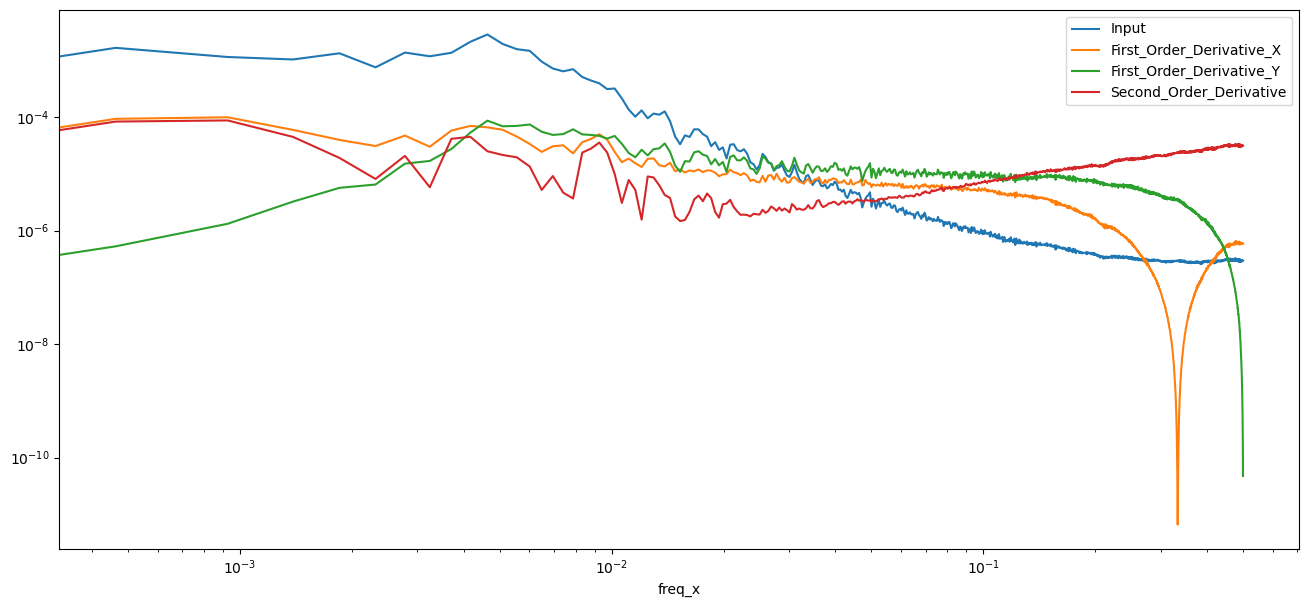

In [10]:
plot_power_spectrum(Input=input_image, 
                    First_Order_Derivative_X=prewitt_output[0],
                    First_Order_Derivative_Y=prewitt_output[1],
                    Second_Order_Derivative=laplacian_output,
                    # Third_Order_Derivative=prewitt_3d_output[:, 0, ...]
                   )

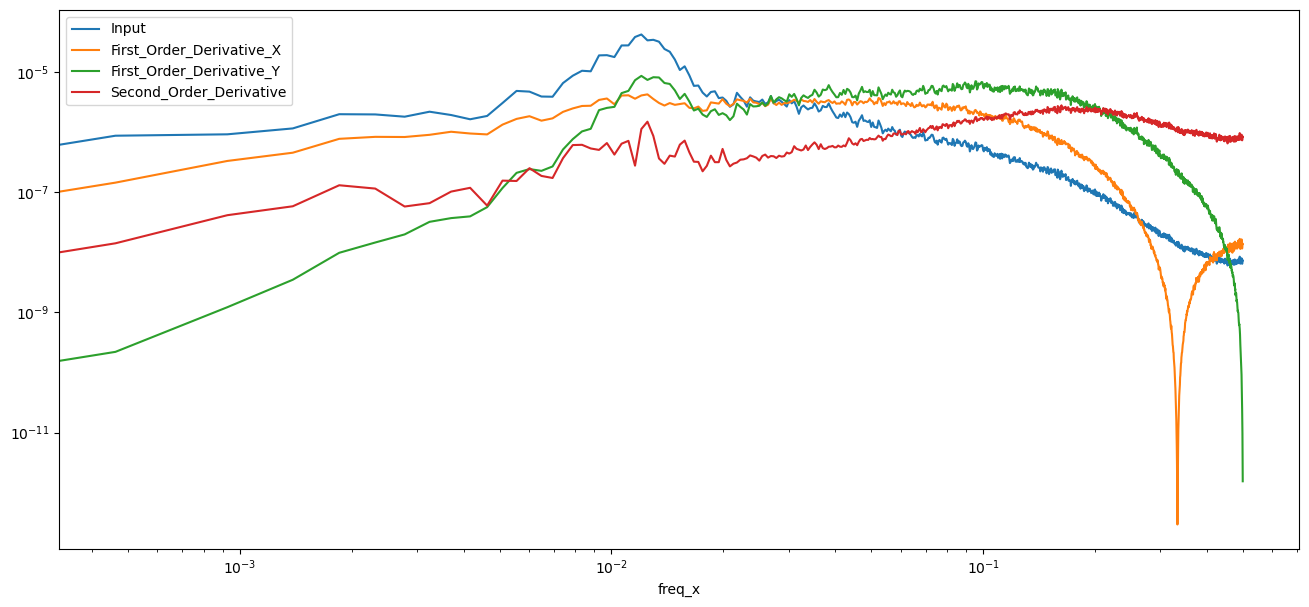

In [7]:
plot_power_spectrum(Input=input_image, 
                    First_Order_Derivative_X=prewitt_output[0],
                    First_Order_Derivative_Y=prewitt_output[1],
                    Second_Order_Derivative=laplacian_output,
                    # Third_Order_Derivative=prewitt_3d_output[:, 0, ...]
                   )

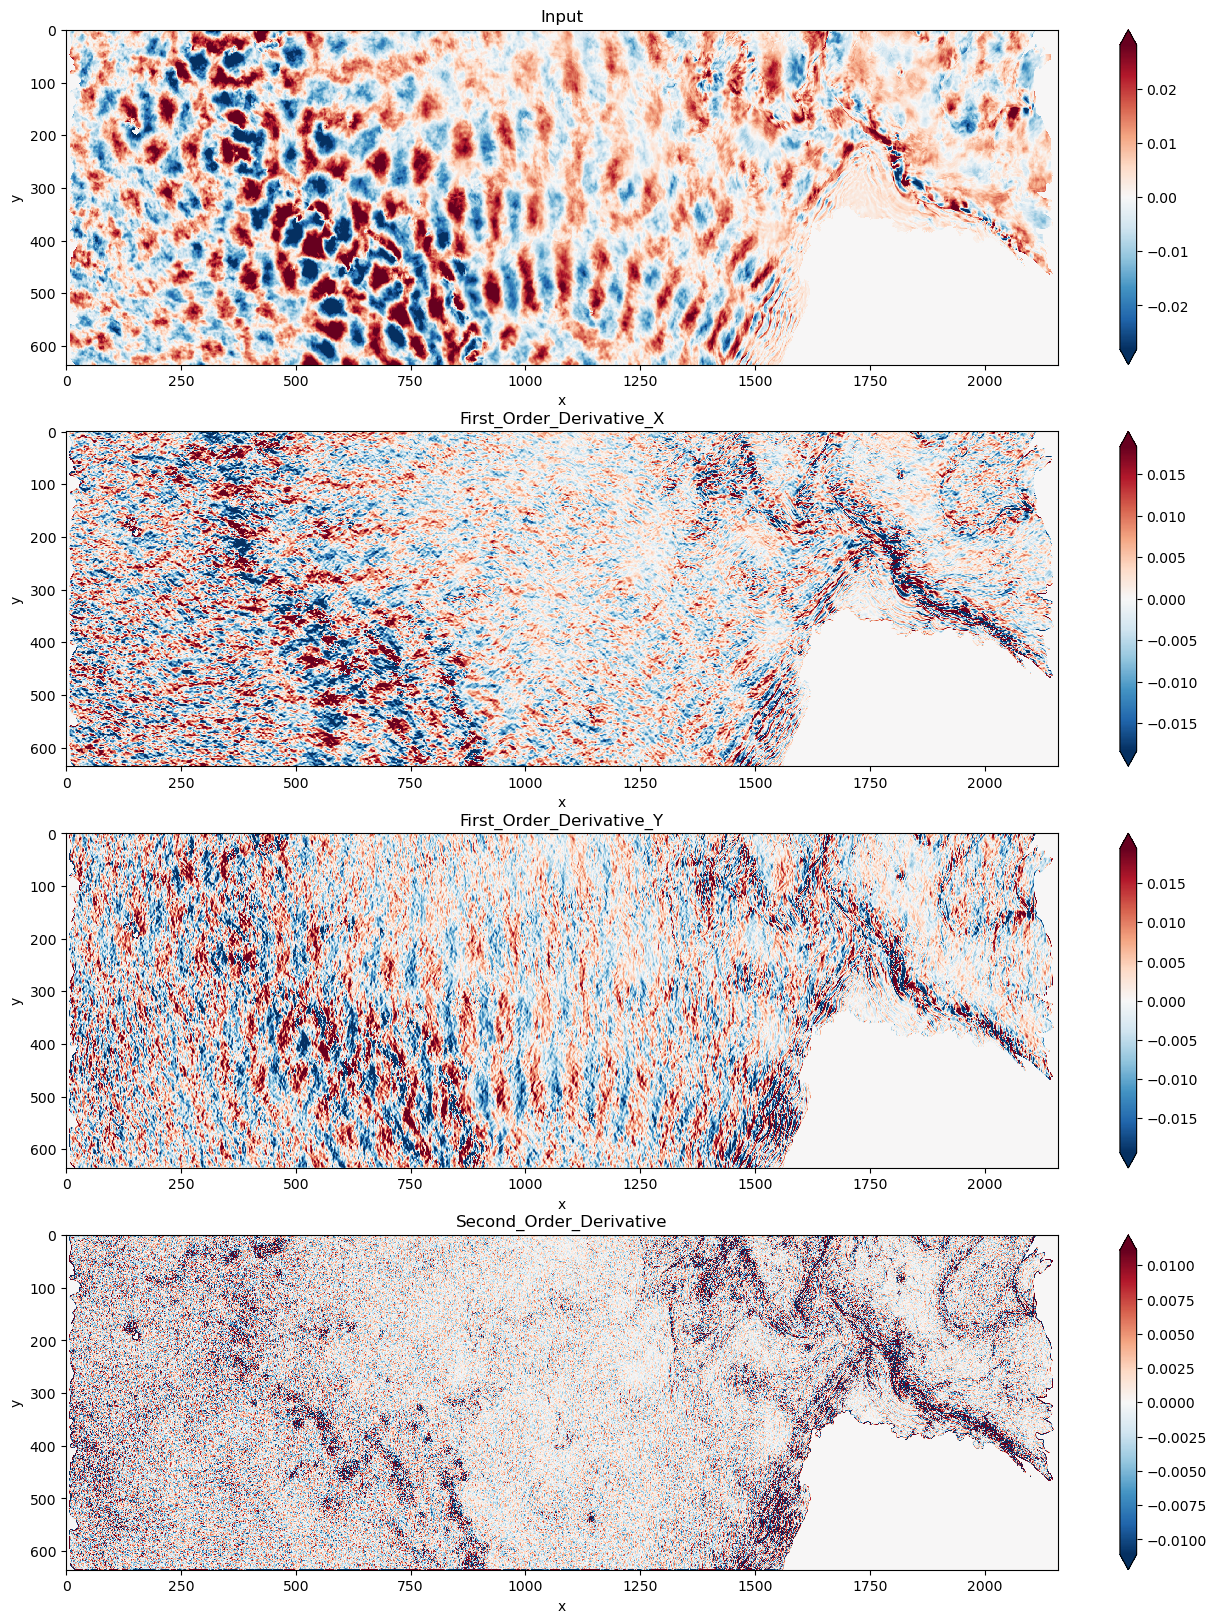

In [8]:
plot_filter_outputs(Input=input_image, 
                    First_Order_Derivative_X=prewitt_output[0],
                    First_Order_Derivative_Y=prewitt_output[1],
                    Second_Order_Derivative=laplacian_output,
                    # Third_Order_Derivative=prewitt_3d_output[:, 0, ...]
                   )

## Load Test Dataset

In [4]:
rng = np.random.default_rng(2019)
arr = np.arange(70)
rng.shuffle(arr)

inputs = da_unfiltered[arr[56:], 56:-56, 56:-56].fillna(0).values 
targets_bm = da_filtered[arr[56:], 56:-56, 56:-56].fillna(0).values
targets_it = da_it[arr[56:], 56:-56, 56:-56].fillna(0).values

In [5]:
print(inputs.shape, targets_bm.shape, targets_it.shape)

(14, 2048, 2048) (14, 2048, 2048) (14, 2048, 2048)


## Utils

In [6]:
def psnr(original, reconstructed):
    
    if isinstance(original, (np.ndarray, np.generic)):
    
        mse = (np.square(original - reconstructed)).mean(axis=(1, 2))
        psnr = 20 * np.log10(2.0 / np.sqrt(mse))
    
    else:
        mse = F.mse_loss(original, reconstructed, reduction='none').mean(dim=(1, 2))
        psnr = 20 * torch.log10(2.0 / torch.sqrt(mse))
    
    return psnr

def ECDF(**kwargs):
    fig, ax = plt.subplots()
    
    for kwarg, value in kwargs.items():
        x = np.sort(value)
        y = np.arange(1, len(value) + 1) / len(value)
        ax.plot(x, y, linestyle='--', alpha=1, label=kwarg)
    
    ax.legend()
    plt.show()

def load_training_reports(checkpoint_root, two_head=False):
    
    RESTORE_FROM = os.path.join('outputs', checkpoint_root, 'snapshots')
    
    if two_head:
        with open(os.path.join(RESTORE_FROM, 'logger.npy'), 'rb') as f:
            loss_arr = np.load(f)
            psnr_bm_arr = np.load(f)
            psnr_it_arr = np.load(f)
        
        return loss_arr, psnr_bm_arr, psnr_it_arr
    else:
        
        with open(os.path.join(RESTORE_FROM, 'logger.npy'), 'rb') as f:
            loss_arr = np.load(f)
            psnr_arr = np.load(f)
    
        return loss_arr, psnr_arr

def load_checkpoint(checkpoint_root, checkpoint_file, model):
    
    print("Loading Checkpoint...")
    RESTORE_FROM = os.path.join('outputs', checkpoint_root, 'snapshots', checkpoint_file, 'model.pth.tar')
    print(RESTORE_FROM)
    
    checkpoint = torch.load(RESTORE_FROM)
    model.load_state_dict(checkpoint["state_dict"])

In [12]:
CNN00_loss, CNN00_psnr = load_training_reports('00-CNN-T05', two_head=False)
CNN02_loss, CNN02_psnr = load_training_reports('00-CNN-T08', two_head=False)
CNN03_loss, CNN03_psnr = load_training_reports('00-CNN-T09', two_head=False)
CNN05_loss, CNN05_psnr = load_training_reports('00-CNN-T12', two_head=False)

In [13]:
RESTORE_FROM = os.path.join('outputs', '00-CNN-T12', 'snapshots')
with open(os.path.join(RESTORE_FROM, 'logger.npy'), 'rb') as f:
    _ = np.load(f)
    _ = np.load(f)
    _ = np.load(f)
    _ = np.load(f)
    CNN05_psnr = np.load(f)

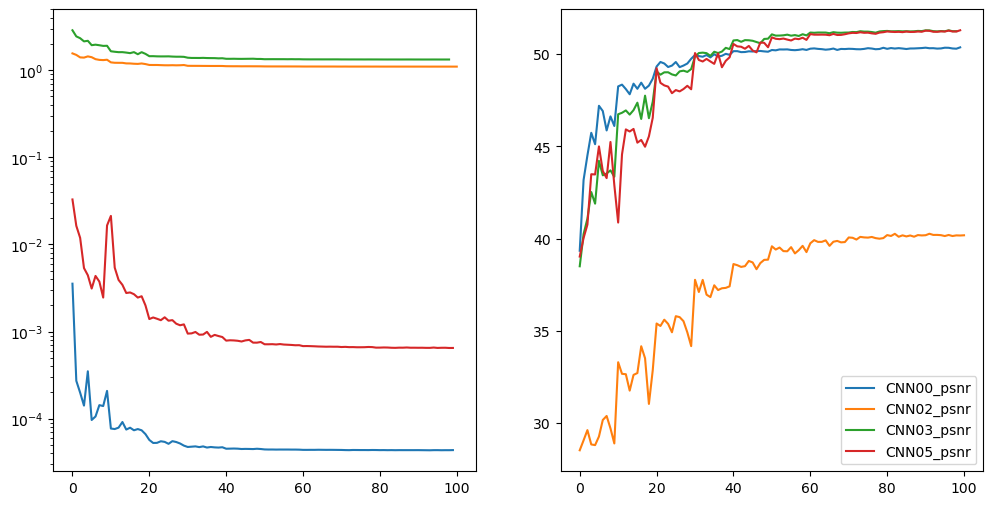

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

ax1.semilogy(CNN00_loss, label='CNN00_loss')
ax1.semilogy(CNN02_loss, label='CNN02_loss')
ax1.semilogy(CNN03_loss, label='CNN03_loss')
ax1.semilogy(CNN05_loss, label='CNN05_loss')

ax2.plot(CNN00_psnr, label='CNN00_psnr')
ax2.plot(CNN02_psnr, label='CNN02_psnr')
ax2.plot(CNN03_psnr, label='CNN03_psnr')
ax2.plot(CNN05_psnr, label='CNN05_psnr')

ax2.legend()
plt.show()

In [46]:
## Load Models

In [16]:
CNN00 = CNN(second_component=False, head_activation=nn.Tanh()); load_checkpoint('00-CNN-T05', 'epoch-090', CNN00)
CNN02 = CNN(second_component=False, head_activation=None); load_checkpoint('00-CNN-T08', 'epoch-100', CNN02)
CNN03 = CNN(second_component=False, head_activation=nn.Tanh()); load_checkpoint('00-CNN-T09', 'epoch-090', CNN03)
CNN05 = CNN(second_component=False, head_activation=nn.Tanh()); load_checkpoint('00-CNN-T12', 'epoch-100', CNN05)

Loading Checkpoint...
outputs/00-CNN-T05/snapshots/epoch-090/model.pth.tar
Loading Checkpoint...
outputs/00-CNN-T08/snapshots/epoch-100/model.pth.tar
Loading Checkpoint...
outputs/00-CNN-T09/snapshots/epoch-090/model.pth.tar
Loading Checkpoint...
outputs/00-CNN-T12/snapshots/epoch-100/model.pth.tar


In [17]:
MinMax_transform_dict = {'inputs' : (-2.0309153, 1.098078), 'targets_it': (-0.121434465, 0.12447834), 'targets_bm': (-2.032202, 1.0936853)}
Standard_transform_dict = {'inputs' : (-0.4315792, 0.5710749), 'targets_it': (2.9930247e-06, 0.009364196), 'targets_bm': (-0.43158054, 0.57093924)}

def transformation(data, transform_parameters, transform_method='MinMax', inverse_transform=False):
    
    if transform_method == 'MinMax':
        
        if inverse_transform:
            data = (data + 1) / 2
            data = data * (transform_parameters[1] - transform_parameters[0]) + transform_parameters[0]
            return data
        
        data = (data - transform_parameters[0]) / (transform_parameters[1] - transform_parameters[0])
        return (2 * data) - 1
    
    if transform_method == 'Standard':
        
        if inverse_transform:
            data = data * transform_parameters[1] + transform_parameters[0]
            return data
        
        data = (data - transform_parameters[0]) / transform_parameters[1]
        return data

def metrics_report(original, recunstructed):
    
    instance_numbers = original.shape[0]
    
    r2 = r2_score(original.reshape(instance_numbers, -1), recunstructed.reshape(instance_numbers, -1))
    mse = mean_squared_error(recunstructed.reshape(instance_numbers, -1), recunstructed.reshape(instance_numbers, -1), squared=False)
    pbias = 100 * np.sum(recunstructed - original) / np.sum(original)
    
    print(f'R2: {r2:.4f}, PBias: {pbias:.4f}, RMSE: {mse:.4f}')

In [18]:
def inference(model, dataset):
    
    dataset_tensor = torch.tensor(dataset, dtype=torch.float32)
    dataset_tensor = torch.unsqueeze(dataset_tensor, 1)
    gens = np.empty((0, 2048, 2048))
    
    model = model.cuda()
    model.eval()
    with torch.no_grad():

        for batch in range(dataset_tensor.size(0)):

            # GPU deployment
            ssh = dataset_tensor[batch, ...].cuda()

            # Compute prediction
            gen = model(ssh).detach().cpu().numpy()           
            
            gens = np.concatenate((gens, gen) , axis=0)
    
    return gens


In [19]:
MinMax_inputs = transformation(inputs, MinMax_transform_dict['inputs'], transform_method='MinMax', inverse_transform=False)
Standard_inputs = transformation(inputs, Standard_transform_dict['inputs'], transform_method='Standard', inverse_transform=False)

MinMax_outputs = transformation(targets_bm, MinMax_transform_dict['targets_bm'], transform_method='MinMax', inverse_transform=False)
Standard_outputs = transformation(targets_bm, Standard_transform_dict['targets_bm'], transform_method='Standard', inverse_transform=False)

In [20]:
CNN00_bm = inference(CNN00, MinMax_inputs)
CNN02_bm = inference(CNN02, Standard_inputs)
CNN03_bm = inference(CNN03, MinMax_inputs)
CNN05_bm = inference(CNN05, MinMax_inputs)

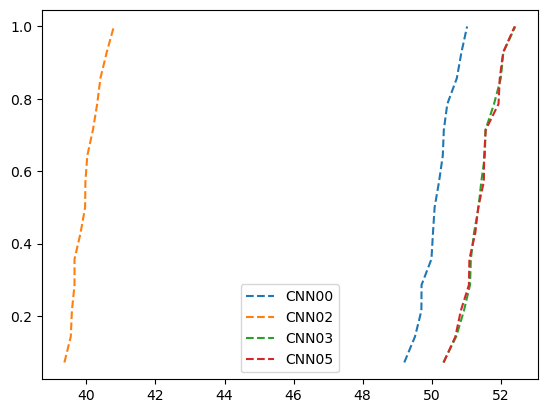

In [21]:
ECDF(CNN00=psnr(MinMax_outputs, CNN00_bm), CNN02=psnr(Standard_outputs, CNN02_bm), CNN03=psnr(MinMax_outputs, CNN03_bm), CNN05=psnr(MinMax_outputs, CNN05_bm))

In [22]:
CNN00_transform_bm = transformation(CNN00_bm, MinMax_transform_dict['targets_bm'], transform_method='MinMax', inverse_transform=True)
CNN02_transform_bm = transformation(CNN02_bm, Standard_transform_dict['targets_bm'], transform_method='Standard', inverse_transform=True)
CNN03_transform_bm = transformation(CNN03_bm, MinMax_transform_dict['targets_bm'], transform_method='MinMax', inverse_transform=True)
CNN05_transform_bm = transformation(CNN05_bm, MinMax_transform_dict['targets_bm'], transform_method='MinMax', inverse_transform=True)

In [23]:
metrics_report(targets_bm, CNN00_transform_bm)
metrics_report(targets_bm, CNN02_transform_bm)
metrics_report(targets_bm, CNN03_transform_bm)
metrics_report(targets_bm, CNN05_transform_bm)

R2: 0.6817, PBias: 0.0911, RMSE: 0.0000
R2: 0.6719, PBias: 0.1496, RMSE: 0.0000
R2: 0.7134, PBias: 0.1263, RMSE: 0.0000
R2: 0.6942, PBias: 0.0906, RMSE: 0.0000


In [61]:
da_bm = xr.DataArray(targets_bm, dims=['z', 'x', 'y'])
da_cnn00 = xr.DataArray(CNN00_transform_bm, dims=['z', 'x', 'y'])
da_cnn02 = xr.DataArray(CNN02_transform_bm, dims=['z', 'x', 'y'])
da_cnn03 = xr.DataArray(CNN03_transform_bm, dims=['z', 'x', 'y'])

ps_bm = xrft.power_spectrum(da_bm, 'x', window='hamming').rename('bm')
ps_cnn00 = xrft.power_spectrum(da_cnn00, 'x', window='hamming').rename('cnn00')
ps_cnn02 = xrft.power_spectrum(da_cnn02, 'x', window='hamming').rename('cnn02')
ps_cnn03 = xrft.power_spectrum(da_cnn03, 'x', window='hamming').rename('cnn03')

metrics_report(ps_bm.values, ps_cnn00.values)
metrics_report(ps_bm.values, ps_cnn02.values)
metrics_report(ps_bm.values, ps_cnn03.values)

R2: -2.0518, PBias: -0.3762, RMSE: 0.0000
R2: 0.2496, PBias: 0.0326, RMSE: 0.0000
R2: 0.2022, PBias: -0.3072, RMSE: 0.0000


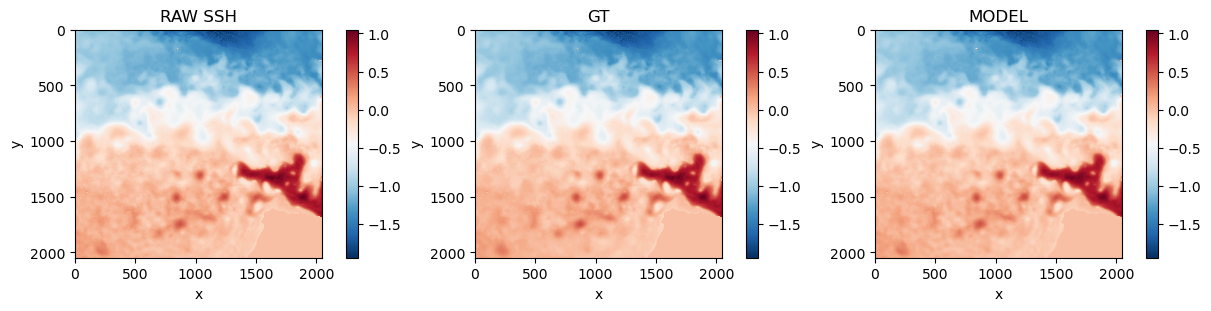

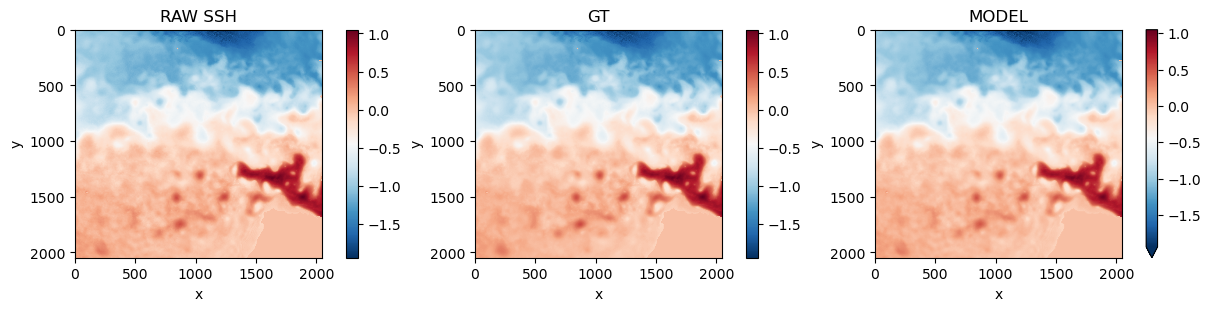

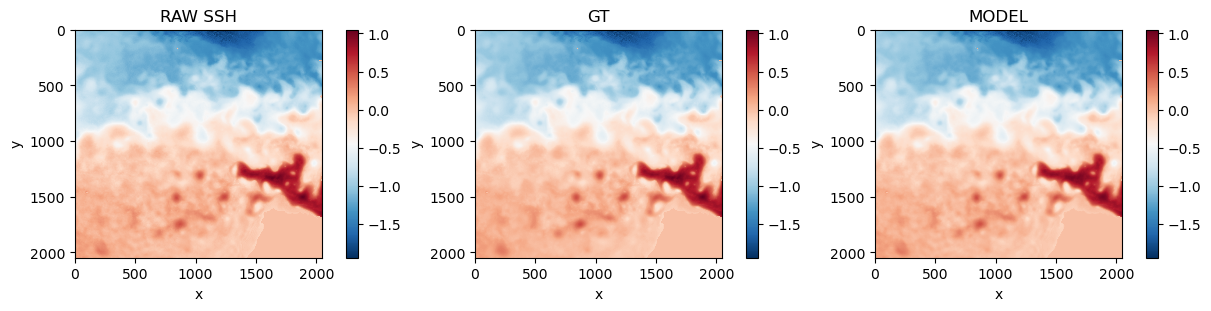

In [25]:
idx = 0
plot_examples(inputs[idx], targets_bm[idx], CNN00_transform_bm[idx])
plot_examples(inputs[idx], targets_bm[idx], CNN02_transform_bm[idx])
plot_examples(inputs[idx], targets_bm[idx], CNN03_transform_bm[idx])

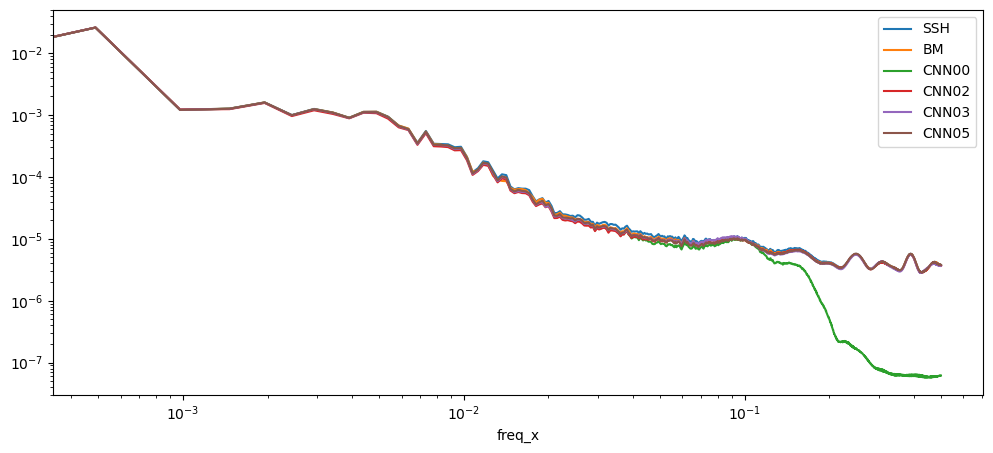

In [26]:
da_ssh = xr.DataArray(inputs[idx], dims=['x', 'y'])
da_bm = xr.DataArray(targets_bm[idx], dims=['x', 'y'])
da_cnn00 = xr.DataArray(CNN00_transform_bm[idx], dims=['x', 'y'])
da_cnn02 = xr.DataArray(CNN02_transform_bm[idx], dims=['x', 'y'])
da_cnn03 = xr.DataArray(CNN03_transform_bm[idx], dims=['x', 'y'])
da_cnn05 = xr.DataArray(CNN05_transform_bm[idx], dims=['x', 'y'])

ps_ssh = xrft.power_spectrum(da_ssh, 'x', window='hamming').rename('ssh')
ps_bm = xrft.power_spectrum(da_bm, 'x', window='hamming').rename('bm')
ps_cnn00 = xrft.power_spectrum(da_cnn00, 'x', window='hamming').rename('cnn00')
ps_cnn02 = xrft.power_spectrum(da_cnn02, 'x', window='hamming').rename('cnn02')
ps_cnn03 = xrft.power_spectrum(da_cnn03, 'x', window='hamming').rename('cnn03')
ps_cnn05 = xrft.power_spectrum(da_cnn05, 'x', window='hamming').rename('cnn05')

fig, ax = plt.subplots(figsize=(12, 5))

(ps_ssh * ps_ssh.freq_x).mean('y').plot(label='SSH', ax=ax)
(ps_bm * ps_bm.freq_x).mean('y').plot(label='BM', ax=ax)
(ps_cnn00 * ps_cnn00.freq_x).mean('y').plot(label='CNN00', ax=ax)
(ps_cnn02 * ps_cnn02.freq_x).mean('y').plot(label='CNN02', ax=ax)
(ps_cnn03 * ps_cnn03.freq_x).mean('y').plot(label='CNN03', ax=ax)
(ps_cnn05 * ps_cnn05.freq_x).mean('y').plot(label='CNN05', ax=ax)

plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.show()